# Deduplication 2nd step  pointwise (with amounts)

sentence 1 = Take TX + merchant1, 

sentence 2 = Take TX + merchant2

label =1 , if merchant 1 = m2



The candidate duplicates for merchant 1 should be retrieved from a first candidate selection step

- Train a classification model  TX <m1> merchant1 <m2> merchant2 = 1,0

- Train a classification model  TX <m1> merchant1, amount m1 <m2> merchant2, amount 2 (to deduplicate existing merchant table) 

- train a binary classification model


- look into architechture modification and add numerical values as concatenation

https://sbert.net/docs/sentence_transformer/training_overview.html#dataset-format

# DATA loading

In [1]:
%pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install awswrangler

Note: you may need to restart the kernel to use updated packages.


In [3]:
import awswrangler as wr

In [4]:
import pandas as pd

In [6]:
# s3_path_training_data = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/cross_encoder/xenc1/train_cons_2024-05-15_2024-05-18_1.parquet"
# df_train = wr.s3.read_parquet(s3_path_training_data)
# print(df_train.shape[0])
# #-------------
# s3_path_test_data = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/cross_encoder/xenc1/test_cons_2024-05-15_2024-05-18_1.parquet"
# df_test = wr.s3.read_parquet(s3_path_test_data)
# print(df_test.shape[0])


from datasets import Dataset, load_dataset, load_from_disk
# ds_train = Dataset.from_pandas(df_train[[label_col,text_col]])
# ds_test = Dataset.from_pandas(df_test[[label_col,text_col]])
ds_train = load_from_disk('/home/sagemaker-user/data/xencdups2/train_dataset')
ds_test = load_from_disk('/home/sagemaker-user/data/xencdups2/test_dataset')
ds_val = load_from_disk('/home/sagemaker-user/data/xencdups2/val_dataset')


In [7]:
label_col = 'label'
text_col = 'text'

# ds_train.save_to_disk('/home/sagemaker-user/data/xencdups/train_dataset')
# ds_test.save_to_disk('/home/sagemaker-user/data/xencdups/test_dataset')

# Load duplicates_names 

In [8]:

# df_duplicates_candidates = wr.s3.read_csv("s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-7800/duplicate_merchant_matching_candidates_N_10_cons_2024-05-15_2024-05-18_1.csv", index_col=None)


In [9]:
# df_duplicates_candidates.head()

In [10]:
# try:
#     df_duplicates_candidates.drop('Unnamed: 0', axis=1, inplace=True)
# except:
#     pass

In [11]:
# from sklearn.model_selection import train_test_split

### Load raw data 

In [12]:
# s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/cons_2024-05-15_2024-05-18_1.parquet/"


# df_data_raw = wr.s3.read_parquet(path=s3_path)
# df_data_raw.shape

In [13]:
# exclude_list = ['DoorDash','Savings','Overdraft Charge','Withdrawal','PayPal','Point Of Sale Withdrawal', 'Adjustment','Cash Withdrawal','Chime','Doordash','Signature','Sezzle'
#  'Zelle',
#  'Chase Bank',
#  'Cash App',
#  'Wells Fargo',
#  'Capital One',
#  'Google Play Store',
#  'Square',
#  'DoorDash',
#  'Citibank',
#  'Toast',
#  'Instacart',
#  'Apple Cash',
#  'Credit',
#  'Earnin',
#  'Klover App','Klarna','Savings','Insufficient Funds / Failed Transaction Fee','Point Of Sale Deposit']

In [14]:
import psutil

# Process.memory_info is expressed in bytes, so convert to megabytes
print(f"RAM used: {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")

RAM used: 314.61 MB


In [15]:
ds_train[0]

{'label': 1.0,
 'text': 'Merchant: #1 Wake County Abc TX: #4 Wake County Abc Boar Amount: -15.7 |SEP| Merchant: Wake County Abc Boa TX: #21 Wake County Abc Boa Amount: -19.2'}

In [16]:
import psutil

# Process.memory_info is expressed in bytes, so convert to megabytes
print(f"RAM used: {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")

RAM used: 314.61 MB


In [17]:
len(ds_train['text'])

1178839

In [18]:
ds_train[0]

{'label': 1.0,
 'text': 'Merchant: #1 Wake County Abc TX: #4 Wake County Abc Boar Amount: -15.7 |SEP| Merchant: Wake County Abc Boa TX: #21 Wake County Abc Boa Amount: -19.2'}

In [19]:
import numpy as np

In [20]:
np.array(ds_train[label_col]).sum()/len(ds_train)

0.22271065005484209

In [21]:
np.array(ds_test[label_col]).sum()/len(ds_test)

0.22132594496978025

# Load model

In [22]:
import torch
torch.cuda.empty_cache()


In [23]:
from transformers import AutoTokenizer

model_name = "google-bert/bert-base-cased"
model_name = "distilbert/distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)


def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)




/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [24]:
#tokenized_ds_train = ds_test.map(tokenize_function, batched=True)
tokenized_ds_train = ds_train.map(tokenize_function, batched=True)
dataset_head = tokenized_ds_train.take(5)
list(dataset_head)

Map:   0%|          | 0/1178839 [00:00<?, ? examples/s]

[{'label': 1.0,
  'text': 'Merchant: #1 Wake County Abc TX: #4 Wake County Abc Boar Amount: -15.7 |SEP| Merchant: Wake County Abc Boa TX: #21 Wake County Abc Boa Amount: -19.2',
  'input_ids': [101,
   6432,
   1024,
   1001,
   1015,
   5256,
   2221,
   5925,
   19067,
   1024,
   1001,
   1018,
   5256,
   2221,
   5925,
   24187,
   3815,
   1024,
   1011,
   2321,
   1012,
   1021,
   1064,
   19802,
   1064,
   6432,
   1024,
   5256,
   2221,
   5925,
   8945,
   2050,
   19067,
   1024,
   1001,
   2538,
   5256,
   2221,
   5925,
   8945,
   2050,
   3815,
   1024,
   1011,
   2539,
   1012,
   1016,
   102,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   

In [25]:
print(f"RAM used: {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")

RAM used: 929.10 MB


In [26]:
#%pip install zstandard


In [27]:
#from datasets import load_dataset

In [28]:
tokenized_ds_val = ds_val.map(tokenize_function, batched=True)
#tokenized_ds_test = ds_test.map(tokenize_function, batched=True)

In [29]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)

2024-06-25 17:40:24.051905: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
print(f"RAM used: {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")

RAM used: 1517.59 MB


In [31]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")
#metric = evaluate.load("precision")

In [32]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [33]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="/home/sagemaker-user/models/xenc3", evaluation_strategy="steps", \
    num_train_epochs=1, per_device_train_batch_size=32, per_device_eval_batch_size=32, \
         eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=100,
    logging_steps=500)

In [34]:
tokenizer.model_max_length

512

In [35]:
tokenizer.pad

<bound method PreTrainedTokenizerBase.pad of DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)>

In [36]:
lens_sentences = [len(x) for x in  ds_train['text']]

In [37]:
max(lens_sentences)

390

In [38]:
len(tokenized_ds_train[0]['input_ids'])

512

In [39]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds_train,
    eval_dataset=tokenized_ds_val
    #compute_metrics=compute_metrics,
)

In [40]:
dir(trainer)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_sm_patterns_to_gitignore',
 '_created_lr_scheduler',
 '_gather_and_numpify',
 '_get_collator_with_removed_columns',
 '_get_eval_sampler',
 '_get_learning_rate',
 '_get_output_dir',
 '_get_train_sampler',
 '_hp_search_setup',
 '_inner_training_loop',
 '_issue_warnings_after_load',
 '_load_best_model',
 '_load_from_checkpoint',
 '_load_optimizer_and_scheduler',
 '_load_rng_state',
 '_loggers_initialized',
 '_maybe_log_save_evaluate',
 '_memory_tracker',
 '_move_model_to_device',
 '_nested_gather',
 '_prepare_input',
 '_prepare_inputs',
 '_push_from_checkpoint',
 '_remove_unused_columns',
 '_report_to_hp_search',
 '_ro

In [41]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
500,0.065800,0.116260
1000,0.024500,0.114795
1500,0.014800,0.132906
2000,0.012300,0.121462
2500,0.011300,0.119877
3000,0.006900,0.134752
3500,0.006500,0.136594
4000,0.005800,0.138576
4500,0.004400,0.122093


KeyboardInterrupt: 

In [ ]:
# 1000 or 2500

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("/home/sagemaker-user/models/xenc1/checkpoint-1500", num_labels=1)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    #train_dataset=tokenized_ds_train,
    eval_dataset=tokenized_ds_val,
    compute_metrics=compute_metrics,
)

In [ ]:
len(tokenized_ds_val)

237500

In [ ]:
len(tokenized_ds_val['label'])

237500

In [ ]:
n_samples_small = 10
ds_val_small = Dataset.from_pandas(df_val[[label_col,text_col]][0:n_samples_small])
tokenized_ds_val_small = ds_val_small.map(tokenize_function, batched=True)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [ ]:
base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)
trainer_base = Trainer(
    model=base_model,
    args=training_args,
    #train_dataset=tokenized_ds_train,
    eval_dataset=tokenized_ds_val,
    compute_metrics=compute_metrics,
)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
predictions_original = trainer_base.predict(tokenized_ds_val_small)

In [ ]:
predictions_original

PredictionOutput(predictions=array([[-0.09304377],
       [-0.06542447],
       [-0.1722931 ],
       [-0.11078063],
       [-0.1245597 ],
       [-0.16795816],
       [-0.11878139],
       [-0.12492839],
       [-0.20494896],
       [-0.19127694]], dtype=float32), label_ids=array([1., 1., 1., 0., 0., 0., 0., 0., 0., 1.], dtype=float32), metrics={'test_loss': 0.5251002907752991, 'test_accuracy': 0.6, 'test_runtime': 0.107, 'test_samples_per_second': 93.5, 'test_steps_per_second': 9.35})

In [ ]:
predictions = trainer.predict(tokenized_ds_val_small)

In [ ]:
tokenized_ds_val_small['label']

[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]

[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]

In [ ]:
predictions[0]

array([[ 0.9968817 ],
       [ 0.9926137 ],
       [ 0.99886316],
       [-0.04816552],
       [-0.03600875],
       [-0.02542846],
       [-0.03979023],
       [-0.05198553],
       [-0.03755949],
       [ 0.9915965 ]], dtype=float32)

In [ ]:
metric = evaluate.load("accuracy")


In [ ]:
ds_val_small

Dataset({
    features: ['label', 'text', 'transaction_id'],
    num_rows: 10
})

In [ ]:
df_predictions = pd.DataFrame(predictions[0], columns=['predictions'])
df_predictions['label'] = ds_val_small['label']
df_predictions['transaction_id'] = ds_val_small['transaction_id']
#df_predictions.set_index('transaction_id', inplace=True)
df_predictions


,predictions,label,transaction_id
0,0.996882,1.0,9803401833
1,0.992614,1.0,9897551358
2,0.998863,1.0,9785988152
3,-0.048166,0.0,9700042820
4,-0.036009,0.0,9987316761
5,-0.025428,0.0,9959855172
6,-0.039790,0.0,9713836600
7,-0.051986,0.0,9805702198
8,-0.037559,0.0,9915227855
9,0.991597,1.0,9859792831


In [ ]:
th = 0.5
pred_acc = (1*(df_predictions['predictions']>0.5) == df_predictions['label']).sum()/df_predictions.shape[0]
true_positives = df_predictions[(df_predictions['label']==1) & (df_predictions['predictions']>=th)].shape[0]
false_positives  = df_predictions[(df_predictions['label']==0) & (df_predictions['predictions']>=th)].shape[0]
pred_precision = true_positives/(true_positives+false_positives)
false_negatives = df_predictions[(df_predictions['label']==1) & (df_predictions['predictions']<th)].shape[0]
print(pred_precision)
pred_recall = true_positives/(true_positives + false_negatives)
print(f"Precision {pred_precision} Recall {pred_recall}")


1.0
Precision 1.0 Recall 1.0


In [ ]:
path_s3_output = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/predictions_dedup/"
fname_s3_out = path_s3_output+"small_dataset"
wr.s3.to_parquet(df_predictions, fname_s3_out)
print(fname_s3_out)

's3://cleo-data-science/transaction_enrichment/experimental_data/caste/predictions_dedup/small_dataset'

In [ ]:
# write predictions to s3 bucket


In [ ]:
len(ds_val_small['label'])

10

In [ ]:
1*(predictions[0]>0.5)

array([[1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1]])

In [ ]:
metric.compute(predictions=1*(predictions[0]>0.5), references=ds_val_small['label'])

{'accuracy': 1.0}

In [ ]:
predictions

PredictionOutput(predictions=array([[ 0.9968817 ],
       [ 0.9926137 ],
       [ 0.99886316],
       [-0.04816552],
       [-0.03600875],
       [-0.02542846],
       [-0.03979023],
       [-0.05198553],
       [-0.03755949],
       [ 0.9915965 ]], dtype=float32), label_ids=array([1., 1., 1., 0., 0., 0., 0., 0., 0., 1.], dtype=float32), metrics={'test_loss': 0.0010095818433910608, 'test_accuracy': 0.6, 'test_runtime': 0.1039, 'test_samples_per_second': 96.289, 'test_steps_per_second': 9.629})

In [ ]:
ds_val_small[8]

{'label': 0.0,
 'text': 'RDS VENDING, LLC PHILADELPHIA [SEP] Rds Vending [SEP] Calmal Vending',
 'transaction_id': 9915227855}

In [ ]:
predictions[0]

array([[ 0.9968817 ],
       [ 0.9926137 ],
       [ 0.99886316],
       [-0.04816552],
       [-0.03600875],
       [-0.02542846],
       [-0.03979023],
       [-0.05198553],
       [-0.03755949],
       [ 0.9915965 ]], dtype=float32)

In [ ]:
ds_val_small[0]

{'label': 1.0,
 'text': 'Betmgm Online [SEP] BetMGM.com [SEP] BetMGM',
 'transaction_id': 9803401833}

In [ ]:
len(predictions)

3

In [ ]:
predictions[0]

array([[ 0.9968817 ],
       [ 0.9926137 ],
       [ 0.99886316],
       [-0.04816552],
       [-0.03600875],
       [-0.02542846],
       [-0.03979023],
       [-0.05198553],
       [-0.03755949],
       [ 0.9915965 ]], dtype=float32)

In [ ]:
ds_val_small['label']

[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]

In [ ]:
predictions[1]

array([1., 1., 1., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [ ]:
predictions[2]

{'test_loss': 0.0010095818433910608,
 'test_accuracy': 0.6,
 'test_runtime': 0.1768,
 'test_samples_per_second': 56.57,
 'test_steps_per_second': 5.657}

In [ ]:
predictions

PredictionOutput(predictions=array([[ 0.9964445 ],
       [ 0.99798816],
       [ 1.0009276 ],
       ...,
       [-0.01006407],
       [-0.00524025],
       [-0.00686787]], dtype=float32), label_ids=array([1., 1., 1., ..., 0., 0., 0.], dtype=float32), metrics={'test_loss': 0.006608151830732822, 'test_accuracy': 0.8007747368421053, 'test_runtime': 2329.7816, 'test_samples_per_second': 101.941, 'test_steps_per_second': 3.186})

In [ ]:

print(predictions.predictions.shape, predictions.label_ids.shape)

NameError: name 'tokenized_datasets' is not defined

In [ ]:
print("Finish here")

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
class PandasDataset(Dataset):
    def __init__(self, dataframe, text_col, label_col):
        self.dataframe = dataframe
        self.text = dataframe[text_col].values  # Assuming 'target' is the label column
        self.labels = dataframe[label_col].values

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.text[idx]
        label = self.labels[idx]
        return text, label

In [ ]:
# dataset = PandasDataset(df_data_raw, )

TypeError: PandasDataset.__init__() missing 2 required positional arguments: 'text_col' and 'label_col'

# Load model

In [ ]:
# from transformers import AutoModelForSequenceClassification

# model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=1)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2024-06-18 12:39:05.971559: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


# def tokenize_function(examples):
#     return tokenizer(examples["text"], padding="max_length", truncation=True)



/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# class TokenizedPandasDataset(Dataset):
#     def __init__(self, dataframe, tokenizer, text_column, label_column):
#         self.dataframe = dataframe
#         self.text = dataframe[text_column].values  # Assuming 'target' is the label column
#         self.labels = dataframe[label_column].values
#         self.tokenizer = tokenizer
#         self.encodings = self.tokenizer(list(self.text), truncation=True, padding=True, max_length=128, return_tensors="pt")

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         item = {key: val[idx] for key, val in self.encodings.items()}
#         item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
#         return item


# # Create tokenized dataset
# #tokenized_dataset = TokenizedPandasDataset(df_data_raw, tokenizer, text_column='text', label_column='label')


In [ ]:
# # Create DataLoader
# dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# i = 0
# # Iterate through the DataLoader
# for batch in dataloader:
#     print(batch)
#     tokenized_batch = tokenizer(batch[0], truncation=True, padding=True)
#     i+=1
#     if i>4:
#         break


[('PURCHASE AUTHORIZED ON 05/14 DAIRY QUEEN # MESA AZ S CARD . Channel: in store. Amount: -7.6 [SEP] Dairy Queen [SEP] Dairy Queen', 'SEZZLE*DD DOORDASHMinneapol is MNSEZZLE*DD D. Channel: None. Amount: -11.7 [SEP] Sezzle [SEP] Ringling Market', 'DAVE INC LOS ANGELES CA 05/15. Channel: None. Amount: 125.0 [SEP] Dave Inc [SEP] Dave Inc', 'Online Banking transfer to CHK Confirmation# . Channel: None. Amount: -4.0 [SEP] Online Banking Transfer [SEP] Online Banking Transfer', 'Recurring Withdrawal Bill Payment - # Spotify USA 877- NY Card . Channel: online. Amount: -11.8 [SEP] Spotify [SEP] Food Stor', "DUNKIN # , SHIPPENSBURG, PA. Channel: in store. Amount: -5.3 [SEP] Dunkin'' Donuts [SEP] Hyatt Resorts", " ZAXBY''S # HERNANDO MS**. Channel: in store. Amount: -18.1 [SEP] Zaxby''s [SEP] Brigit", 'PURCHASE FLEX FINANCE NEW YORK NY . Channel: online. Amount: -813.5 [SEP] Flex Finance [SEP] Flex Finance'), tensor([1, 0, 1, 1, 0, 0, 0, 1])]
[('NCIC INMATE PHONE SERVI 903- TX. Channel: online. 

In [ ]:
len(tokenized_batch['input_ids'])

8

In [ ]:
# i_train = 1000

# small_train_dataset = PandasDataset(df_data_raw[0:i_train])
# small_val_dataset = PandasDataset(df_data_raw[i_train:2*i_train])

In [ ]:
# train_small_dataloader = DataLoader(small_train_dataset, batch_size=8, shuffle=True)


In [ ]:
# from tqdm.auto import tqdm

# progress_bar = tqdm(range(num_training_steps))

# model.train()
# for epoch in range(num_epochs):
#     for batch in train_dataloader:
#         batch = {k: v.to(device) for k, v in batch.items()}
#         outputs = model(**batch)
#         loss = outputs.loss
#         loss.backward()

#         optimizer.step()
#         lr_scheduler.step()
#         optimizer.zero_grad()
#         progress_bar.update(1)

In [ ]:
# from transformers import TrainingArguments

# training_args = TrainingArguments(output_dir="test_trainer")

In [ ]:
# import numpy as np
# import evaluate

# metric = evaluate.load("accuracy")

In [ ]:
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return metric.compute(predictions=predictions, references=labels)

In [ ]:
# train_encodings = tokenizer(train_texts, truncation=True, padding=True)
# val_encodings = tokenizer(val_texts, truncation=True, padding=True)
# test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
# from transformers import TrainingArguments, Trainer

# training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [ ]:
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=small_train_dataset,
#     eval_dataset=small_eval_dataset,
#     compute_metrics=compute_metrics,
# )

In [ ]:
# I don't wantt o tokenize all the dataset at once, but rather tokenize

In [ ]:
torch.cuda.empty_cache()

In [ ]:
%pip install accelerate==0.27.2
%pip install sentence-transformers
%pip install umap-learn
#%pip install cleodata --extra-index-url "https://aws:$(aws codeartifact get-authorization-token --domain meetcleo --domain-owner 878877078763 --query authorizationToken --output text)@meetcleo-878877078763.d.codeartifact.us-east-1.amazonaws.com/pypi/meetcleo-releases/simple/"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 27.0 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.21.0
    Uninstalling accelerate-0.21.0:
      Successfully uninstalled accelerate-0.21.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 0.8.3 requires accelerate<0.22.0,>=0.21.0, but you have accelerate 0.27.2 which is incompatible.
autogluon-multimodal 0.8.3 requires pandas<1.6,>=1.4.1, but you have pandas 2.1.4 which is incompatible.
autogluon-multimodal 0.8.3 requires pytorch-lightning<1.10.0,>=1.9.0, but you have pytorch-lightning 2.0.9 which is incompatible.
autogluon-multimodal 0.8.3 requires scikit-learn<1.4.1,>=1.1, but you have scikit-learn 1.4.2 which is incompatible.
autogluon-multimodal 0.8.3 requires torch<1.14,>=1.9, but you have torch 2.0.0.post304 which is incompa

In [ ]:
# %pip install awswrangler
# %pip install --upgrade sentence_transformers

In [ ]:
import pandas as pd
from datetime import datetime
import awswrangler as wr
import boto3
from botocore.exceptions import ClientError
from io import StringIO
#from fastparquet import ParquetFile
#boto3.setup_default_session(profile_name='DataScientist-878877078763')
# from cleodata.utils.secrets import get_secret
#from cleodata.sources.sync.sync import SyncDataSource
#redshift_source = SyncDataSource("data_exploration", use_redshift=True, redshift_cluster="cleo-production-redshift", redshift_db="cleo")

In [ ]:
import pandas as pd
import torch
from sklearn.metrics.pairwise import cosine_similarity
import umap
from sentence_transformers import SentenceTransformer, models
from sentence_transformers import SentenceTransformer, InputExample
from torch.utils.data import DataLoader
from sentence_transformers import losses
from sklearn.model_selection import train_test_split

2024-06-19 14:37:50.621423: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
import torch
print(torch.__version__)

2.0.0.post304


In [ ]:
# s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/trans_2024-05-14_2024-05-14_top_2001.parquet"
# s3_path = "https://cleo-data-science.s3.amazonaws.com/transaction_enrichment/experimental_data/caste/trx-merchant-pair/trans_2024-05-18_2024-05-18_top_1_39000.parquet/"
# s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/cons_2024-05-15_2024-05-18_1.parquet/"

# df_data_raw = wr.s3.read_parquet(path=s3_path)
# df_data_raw.shape

In [ ]:
print(torch.cuda.device_count())

1


In [ ]:
df_data_raw.head()

,transaction_id,amount,text,merchant_name,merchant_name2,description_combined_processed,label,sent_m1,sent_m2
0,9711158815,-2.25,MOBILE PURCHASE 0505 HART-FLAMINGOFARES.COM TA...,Hart Flamingofares,Hart-flamingofares,MOBILE PURCHASE 0505 HART-FLAMINGOFARES.COM TA...,1,MOBILE PURCHASE 0505 HART-FLAMINGOFARES.COM TA...,MOBILE PURCHASE 0505 HART-FLAMINGOFARES.COM TA...
1,9740980806,-200.00,PURCHASE AUTHORIZED ON 05/07 KIDS UNLIMITED IN...,Kids Unlimited,Kids Unlimited Inc,PURCHASE AUTHORIZED ON 05/07 KIDS UNLIMITED IN...,1,PURCHASE AUTHORIZED ON 05/07 KIDS UNLIMITED IN...,PURCHASE AUTHORIZED ON 05/07 KIDS UNLIMITED IN...
2,9796548131,-30.00,CHECKCARD 0511 EDWARDGURKA-MATCO XXXXX96003 TX...,Edwardgurka Matcotools Rosharon,Edwardgurka-matco,CHECKCARD 0511 EDWARDGURKA-MATCO XXXXX96003 TX...,1,CHECKCARD 0511 EDWARDGURKA-MATCO XXXXX96003 TX...,CHECKCARD 0511 EDWARDGURKA-MATCO XXXXX96003 TX...
3,9978142547,-25.04,Caseys [SEP] Casey''s Lincoln [SEP] Casey''s,Casey''s Lincoln,Casey''s,Caseys,1,Caseys |SEP| Casey''s Lincoln,Caseys |SEP| Casey''s
4,9694955604,-13.69,Point Of Sale Withdrawal HUGO INSURANCE SOLNHT...,With,Hugo Insurance,Point Of Sale Withdrawal HUGO INSURANCE SOLNHT...,1,Point Of Sale Withdrawal HUGO INSURANCE SOLNHT...,Point Of Sale Withdrawal HUGO INSURANCE SOLNHT...


In [ ]:
#%pip install s3fs --upgrade
#import s3fs

In [ ]:
label_col = 'label'
text_col = "description_combined_processed"

In [ ]:
df_ , df_test, y_, y_test = train_test_split(df_data_raw, df_data_raw[label_col], test_size = 0.05, random_state=1)
df_train, df_val, y_train, y_val = train_test_split(df_, df_[label_col], test_size = 0.1, random_state=1)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
print(df_train.shape[0], df_val.shape[0], df_test.shape[0])

4275000 475000 250000


In [ ]:
text_col = "description_combined_processed"

In [ ]:
df_train['len_sentence'] = df_train[text_col].apply(lambda x: len(x.split(' ')))
print(df_train['len_sentence'].max())

45


In [ ]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers import SentenceTransformer, InputExample
from torch.utils.data import DataLoader

In [ ]:

word_embedding_model = models.Transformer("bert-base-uncased", max_seq_length=128)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
#pd.set_option('display.float_format', lambda x: '%.f' % x)
#estimate maximum tokenized length
df_train['len_sentence'].describe()

count    4.275000e+06
mean     7.572865e+00
std      4.185147e+00
min      1.000000e+00
25%      4.000000e+00
50%      7.000000e+00
75%      1.100000e+01
max      4.500000e+01
Name: len_sentence, dtype: float64

In [ ]:
print(model.max_seq_length)
model.max_seq_length = 128
print(model.max_seq_length)

128
128


In [ ]:
df_train.head()

,transaction_id,amount,text,merchant_name,merchant_name2,description_combined_processed,label,sent_m1,sent_m2,len_sentence
0,10038658361,-40.00,Cleo Ai [SEP] Cleo [SEP] Financial Er,Cleo,Financial Er,Cleo Ai,0,Cleo Ai |SEP| Cleo,Cleo Ai |SEP| Financial Er,2
1,10018806520,-15.00,951231 PURCHASE-SIG TODD''S PLACE EXP SHELBYVI...,Todd''s Place Express C,Grs Service Stat,951231 PURCHASE-SIG TODD''S PLACE EXP SHELBYVI...,0,951231 PURCHASE-SIG TODD''S PLACE EXP SHELBYVI...,951231 PURCHASE-SIG TODD''S PLACE EXP SHELBYVI...,9
2,9985997014,-20.05,DD DOORDASH ONTHEBORD 855-973-1040 CA [SEP] Do...,Doordash,Teds Bulletin,DD DOORDASH ONTHEBORD 855-973-1040 CA,0,DD DOORDASH ONTHEBORD 855-973-1040 CA |SEP| Do...,DD DOORDASH ONTHEBORD 855-973-1040 CA |SEP| Te...,5
3,10120071730,-10.05,PURCHASE AUTHORIZED ON 05/14 7-ELEVEN Newport ...,7 Eleven,Zippy J,PURCHASE AUTHORIZED ON 05/14 7-ELEVEN Newport ...,0,PURCHASE AUTHORIZED ON 05/14 7-ELEVEN Newport ...,PURCHASE AUTHORIZED ON 05/14 7-ELEVEN Newport ...,11
4,9873180985,-30.00,CHECKCARD 0518 LION MART NO Memphis TN [SEP] L...,Lion Mart,Premier Cstore,CHECKCARD 0518 LION MART NO Memphis TN,0,CHECKCARD 0518 LION MART NO Memphis TN |SEP| L...,CHECKCARD 0518 LION MART NO Memphis TN |SEP| P...,7


In [ ]:
one_sent = df_train[text_col][0]
print(df_train[text_col][1])

951231 PURCHASE-SIG TODD''S PLACE EXP SHELBYVILLE KY 00408192 951231


In [ ]:
df_train['label'] = df_train['label'].astype('float32')
#df_train['true_label'] = df_train['true_label'].astype('float32')
#train_examples = [InputExample(texts = [df_train.loc[i,'sentence'], df_train.loc[i,'merchant_name_combined']], label=df_train.loc[i,'true_label']  ) for i in range(df_train.shape[0])]

In [ ]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

In [ ]:
from torch.utils.data import Dataset, DataLoader
from sentence_transformers.losses import CoSENTLoss


In [ ]:
df_data_raw

,transaction_id,amount,text,merchant_name,merchant_name2,description_combined_processed,label,sent_m1,sent_m2
0,9711158815,-2.25,MOBILE PURCHASE 0505 HART-FLAMINGOFARES.COM TA...,Hart Flamingofares,Hart-flamingofares,MOBILE PURCHASE 0505 HART-FLAMINGOFARES.COM TA...,1,MOBILE PURCHASE 0505 HART-FLAMINGOFARES.COM TA...,MOBILE PURCHASE 0505 HART-FLAMINGOFARES.COM TA...
1,9740980806,-200.00,PURCHASE AUTHORIZED ON 05/07 KIDS UNLIMITED IN...,Kids Unlimited,Kids Unlimited Inc,PURCHASE AUTHORIZED ON 05/07 KIDS UNLIMITED IN...,1,PURCHASE AUTHORIZED ON 05/07 KIDS UNLIMITED IN...,PURCHASE AUTHORIZED ON 05/07 KIDS UNLIMITED IN...
2,9796548131,-30.00,CHECKCARD 0511 EDWARDGURKA-MATCO XXXXX96003 TX...,Edwardgurka Matcotools Rosharon,Edwardgurka-matco,CHECKCARD 0511 EDWARDGURKA-MATCO XXXXX96003 TX...,1,CHECKCARD 0511 EDWARDGURKA-MATCO XXXXX96003 TX...,CHECKCARD 0511 EDWARDGURKA-MATCO XXXXX96003 TX...
3,9978142547,-25.04,Caseys [SEP] Casey''s Lincoln [SEP] Casey''s,Casey''s Lincoln,Casey''s,Caseys,1,Caseys |SEP| Casey''s Lincoln,Caseys |SEP| Casey''s
4,9694955604,-13.69,Point Of Sale Withdrawal HUGO INSURANCE SOLNHT...,With,Hugo Insurance,Point Of Sale Withdrawal HUGO INSURANCE SOLNHT...,1,Point Of Sale Withdrawal HUGO INSURANCE SOLNHT...,Point Of Sale Withdrawal HUGO INSURANCE SOLNHT...
...,...,...,...,...,...,...,...,...,...
4999995,10145501441,-6.35,GOOGLE *Playrix Games [SEP] Playrix Games [SEP...,Playrix Games,King,GOOGLE *Playrix Games,0,GOOGLE *Playrix Games |SEP| Playrix Games,GOOGLE *Playrix Games |SEP| King
4999996,10145558378,-2.10,Signature POS Debit 05/03 VA RIDGEWAY CMSVEND*...,CMS Vending Machines,Camsoda,Signature POS Debit 05/03 VA RIDGEWAY CMSVEND*...,0,Signature POS Debit 05/03 VA RIDGEWAY CMSVEND*...,Signature POS Debit 05/03 VA RIDGEWAY CMSVEND*...
4999997,10145558378,-2.10,Signature POS Debit 05/03 VA RIDGEWAY CMSVEND*...,CMS Vending Machines,Rccl Applepay,Signature POS Debit 05/03 VA RIDGEWAY CMSVEND*...,0,Signature POS Debit 05/03 VA RIDGEWAY CMSVEND*...,Signature POS Debit 05/03 VA RIDGEWAY CMSVEND*...
4999998,10145558378,-2.10,Signature POS Debit 05/03 VA RIDGEWAY CMSVEND*...,CMS Vending Machines,Area,Signature POS Debit 05/03 VA RIDGEWAY CMSVEND*...,0,Signature POS Debit 05/03 VA RIDGEWAY CMSVEND*...,Signature POS Debit 05/03 VA RIDGEWAY CMSVEND*...


In [ ]:
text_col1 = 'sent_m1'
text_col2 = 'sent_m2'

In [ ]:
from datasets import Dataset

ds_train = Dataset.from_pandas(df_train[[label_col,text_col1,text_col2]])
ds_val = Dataset.from_pandas(df_val[[label_col,text_col1,text_col2]])
ds_test = Dataset.from_pandas(df_test[[label_col,text_col1,text_col2]])

ds_train = ds_train.rename_columns({label_col: "score",text_col1:"sentence1", text_col2:"sentence2"})
ds_val = ds_val.rename_columns({label_col: "score",text_col1:"sentence1", text_col2:"sentence2"})
ds_test = ds_test.rename_columns({label_col: "score",text_col1:"sentence1", text_col2:"sentence2"})



In [ ]:
ds_test

Dataset({
    features: ['score', 'sentence1', 'sentence2'],
    num_rows: 250000
})

In [ ]:
import os
directory = "/home/sagemaker-user/logs"

# Check if the directory already exists
if not os.path.exists(directory):
    # Create the directory
    os.makedirs(directory)
    print("Directory created successfully!")
else:
    print("Directory already exists!")

Directory created successfully!


In [ ]:
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers.training_args import BatchSamplers
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction
from sentence_transformers import SentenceTransformerTrainer

In [ ]:
args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir="/home/sagemaker-user/models/model11",
    # Optional training parameters:
    num_train_epochs=3,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    warmup_ratio=0.1,
    fp16=True,  # Set to False if you get an error that your GPU can't run on FP16
    bf16=False,  # Set to True if you have a GPU that supports BF16
    batch_sampler=BatchSamplers.NO_DUPLICATES,  # losses that use "in-batch negatives" benefit from no duplicates
    # Optional tracking/debugging parameters:
    evaluation_strategy="steps", #eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=100,
    logging_steps=500,
    run_name="test1",  # Will be used in W&B if `wandb` is installed
    load_best_model_at_end= True,
    logging_dir="/home/sagemaker-user/logs",
)

In [ ]:
ds_val[0]

{'score': 1,
 'sentence1': 'Betmgm Online |SEP| BetMGM.com',
 'sentence2': 'Betmgm Online |SEP| BetMGM'}

In [ ]:
dev_evaluator = EmbeddingSimilarityEvaluator(
    sentences1=df_val[text_col1],
    sentences2=df_val[text_col2],
    scores=df_val[label_col],
    main_similarity=SimilarityFunction.COSINE,
    name="sts-dev",
)

In [ ]:
#dev_evaluator(model)


In [ ]:
train_loss = CoSENTLoss(model)

In [ ]:
# 7. Create a trainer & train
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    loss=train_loss,
    #evaluator=dev_evaluator,
)
trainer.train()
#resume_from_checkpoint="/home/sagemaker-user/models/model9/checkpoint-1600"

Detected kernel version 4.14.344, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss,Validation Loss
500,7.150000,3.296224
1000,3.264200,1.996672
1500,2.353200,1.591059
2000,1.793400,1.385806
2500,1.354700,1.016969
3000,1.394100,0.773053
3500,1.073000,0.867277
4000,0.821800,0.730691
4500,0.955300,0.662750


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

In [ ]:
# # (Optional) Evaluate the trained model on the test set
# test_evaluator = TripletEvaluator(
#     anchors=df_test["sentence"],
#     positives=df_test["true_merchant_name_combined"],
#     negatives=test_dataset["true_label"],
#     name="pairs-test1",
# )
# test_evaluator(model)

# 8. Save the trained model
model.save_pretrained("/home/sagemaker-user/models/model9final")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [ ]:
#!ls ./models/model1/checkpoint-600

1_Pooling			   scheduler.pt
README.md			   sentence_bert_config.json
config.json			   special_tokens_map.json
config_sentence_transformers.json  tokenizer.json
model.safetensors		   tokenizer_config.json
modules.json			   trainer_state.json
optimizer.pt			   training_args.bin
rng_state.pth			   vocab.txt


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
#copy 
import os
import boto3
from botocore.exceptions import NoCredentialsError, PartialCredentialsError

def upload_directory_to_s3(local_directory, bucket_name, s3_directory):
    s3_client = boto3.client('s3')

    for root, dirs, files in os.walk(local_directory):
        for file in files:
            local_path = os.path.join(root, file)
            relative_path = os.path.relpath(local_path, local_directory)
            s3_path = os.path.join(s3_directory, relative_path)

            try:
                s3_client.upload_file(local_path, bucket_name, s3_path)
                print(f'Successfully uploaded {local_path} to s3://{bucket_name}/{s3_path}')
            except FileNotFoundError:
                print(f'The file {local_path} was not found')
            except NoCredentialsError:
                print('Credentials not available')
            except PartialCredentialsError:
                print('Incomplete credentials provided')

# Example usage
local_directory = "/home/sagemaker-user/models/model4""
bucket_name = 'cleo-data-science'
s3_directory = "transaction_enrichment/experimental_data/caste/pairs_model/model4"

upload_directory_to_s3(local_directory, bucket_name, s3_directory)


Successfully uploaded ./models/model1/checkpoint-600/config_sentence_transformers.json to s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairs_model/model1-checkpoint600/config_sentence_transformers.json
Successfully uploaded ./models/model1/checkpoint-600/config.json to s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairs_model/model1-checkpoint600/config.json
Successfully uploaded ./models/model1/checkpoint-600/model.safetensors to s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairs_model/model1-checkpoint600/model.safetensors
Successfully uploaded ./models/model1/checkpoint-600/tokenizer_config.json to s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairs_model/model1-checkpoint600/tokenizer_config.json
Successfully uploaded ./models/model1/checkpoint-600/special_tokens_map.json to s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairs_model/model1-checkpoint600/special_t

In [ ]:
## 
#model = SentenceTransformer("./models/model1/checkpoint-600")


In [ ]:
list_unique_merchants = df_train['merchant_name_combined'].tolist()
embeddings_merchants = model.encode(list_unique_merchants)
embeddings_merchants.shape

In [ ]:
df_test['pred_merchant'] = None
df_test['pred_prob'] = 0.0
batch_size = 1000

In [ ]:
df_test.shape

(5000, 10)

In [ ]:
for istart in np.arange(0, df_test.shape[0]+1, batch_size):
    iend = min(df_test.shape[0],istart + batch_size)
    if iend> istart:
        print(istart, iend)
        tx_embeddings = model.encode(df_test['sentence'][istart:iend].tolist())
        similarities = model.similarity(tx_embeddings, embeddings_merchants)
        print(similarities.shape)
        max_vals = torch.max(similarities, axis=1)
        max_probs = max_vals[0]
        ix_max_merchants = max_vals[1]
        predicted_merchant = [list_unique_merchants[i] for i in ix_max_merchants]
        df_test.loc[istart:iend-1,'pred_merchant'] =  predicted_merchant
        df_test.loc[istart:iend-1,'pred_prob'] =  np.array(max_probs)

0 1000
torch.Size([1000, 85500])
1000 2000
torch.Size([1000, 85500])
2000 3000
torch.Size([1000, 85500])
3000 4000
torch.Size([1000, 85500])
4000 5000
torch.Size([1000, 85500])


In [ ]:
ntrue = df_test[df_test['pred_merchant'] == df_test['true_merchant_name_combined']].shape[0]

precision = ntrue/df_test.shape[0]
print(precision)

0.9052


In [ ]:
ntrue = df_test[(df_test['pred_merchant'] == df_test['true_merchant_name_combined']) & (df_test['pred_prob']>0.8)].shape[0]

accuracy = ntrue/df_test.shape[0]
print(accuracy)

In [ ]:
#tp/tp + fp



In [ ]:
df_no_match = df_test[df_test['pred_merchant'] != df_test['true_merchant_name_combined']]
df_no_match.reset_index(drop=True, inplace=True)
df_no_match

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label,pred_merchant,pred_prob
0,9796686754,Wal-Mart Super WAL-SAMS SPRINGFIELD MO. Channe...,Wal-Mart Super WAL-SAMS SPRINGFIELD MO. Type: ...,Wal-Mart Super WAL-SAMS SPRINGFIELD MO,Walmart,Smith''s,0,0.310292,Wal Wal-martsuper,0.799137
1,9799290885,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,Walmart,Synchrony,0,0.232759,Wal Wal-martsuper,0.775473
2,9798904474,Walmart.com Bentonville AR XX SIG PURCH 05/13 ...,Walmart.com Bentonville AR XX SIG PURCH 05/13 ...,Walmart.com Bentonville AR XX SIG PURCH 05/13 ...,Walmart,QuikTrip,0,0.075148,Wal Wal-martsuper,0.751793
3,9801927063,PURCHASE AUTHORIZED ON 05/11 WALMART.COM 800-9...,PURCHASE AUTHORIZED ON 05/11 WALMART.COM 800-9...,PURCHASE AUTHORIZED ON 05/11 WALMART.COM 800-9...,Walmart,Cash App,0,0.078535,Wal Wal-martsuper,0.735269
4,9799263021,05/13 22:02 WAL-MART # JONESBORO AR CKCD DEBIT...,05/13 22:02 WAL-MART # JONESBORO AR CKCD DEBIT...,05/13 22:02 WAL-MART # JONESBORO AR CKCD DEBIT,Walmart,Marathon Petroleum,0,0.257865,Wal Wal-martsuper,0.751371
...,...,...,...,...,...,...,...,...,...,...
469,9807244423,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,Walmart,Spinstersis,0,0.051089,Wal Wal-martsuper,0.772779
470,9808452776,Walmart.com 05/14 #XXXXX REFUND Walmart.com Be...,Walmart.com 05/14 #XXXXX REFUND Walmart.com Be...,Walmart.com 05/14 #XXXXX REFUND Walmart.com Be...,Walmart,K Stop Convenience,0,0.018743,Wal Wal-martsuper,0.713919
471,9798778036,Point of Sale Debit L341 TIME 04:30 PM DATE 05...,Point of Sale Debit L341 TIME 04:30 PM DATE 05...,Point of Sale Debit L341 TIME 04:30 PM DATE 05...,Walmart,Ross Stores,0,0.114881,Wal Wal-martsuper,0.766499
472,9807593604,CHECKCARD WALMART STA ELENA LA LIBERTAD XXXXX ...,CHECKCARD WALMART STA ELENA LA LIBERTAD XXXXX ...,CHECKCARD WALMART STA ELENA LA LIBERTAD XXXXX ...,Walmart,Lyft,0,0.116438,Wal Wal-martsuper,0.751746


In [ ]:
df_no_match.drop_duplicates(subset = ['true_merchant_name_combined','pred_merchant'])

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label,pred_merchant,pred_prob
0,9796686754,Wal-Mart Super WAL-SAMS SPRINGFIELD MO. Channe...,Wal-Mart Super WAL-SAMS SPRINGFIELD MO. Type: ...,Wal-Mart Super WAL-SAMS SPRINGFIELD MO,Walmart,Smith''s,0,0.310292,Wal Wal-martsuper,0.799137
13,9799066977,ONLINE TRANSFER FROM MCDONALD J WELLS FARGO CL...,ONLINE TRANSFER FROM MCDONALD J WELLS FARGO CL...,ONLINE TRANSFER FROM MCDONALD J WELLS FARGO CL...,Wells Fargo,Empower,0,0.416453,McDonald''s,0.939226
18,9813217231,POS PURCHASE POS WM SUPERCENTER GREENVILLE PA....,POS PURCHASE POS WM SUPERCENTER GREENVILLE PA....,POS PURCHASE POS WM SUPERCENTER GREENVILLE PA,Walmart,RaceTrac,0,0.288263,McDonald''s,0.630497
36,9795670664,POS PURCH : WM SUPERCENTER # GA BAXLEY WM SUPE...,POS PURCH : WM SUPERCENTER # GA BAXLEY WM SUPE...,POS PURCH : WM SUPERCENTER # GA BAXLEY WM SUPE...,Walmart,Synchrony,0,0.000095,U.s. Retailers,0.642287
269,9800470341,ZELLE TO FEDRA ON 05/14 REF #RP0S842CWR WALMAR...,ZELLE TO FEDRA ON 05/14 REF #RP0S842CWR WALMAR...,ZELLE TO FEDRA ON 05/14 REF #RP0S842CWR WALMART,Walmart,Bank of America,0,0.030782,Zelle,0.705138


In [ ]:
df_no_match.loc[13,'sentence']

'ONLINE TRANSFER FROM MCDONALD J WELLS FARGO CLEAR ACCESS BANKING XXXXXX REF #IB0N78QNRB ON 05/14/24. Channel: None. Amount: 90.0'

In [ ]:
df_no_match.loc[269,'sentence']

'ZELLE TO FEDRA ON 05/14 REF #RP0S842CWR WALMART. Channel: None. Amount: -98.77'

In [ ]:
# do a precision-recall curve

(4526, 10)

In [ ]:
df_train['true_merchant_name_combined'].value_counts()

true_merchant_name_combined
Amazon         12848
Cash App       12840
Earnin         12825
Wells Fargo    12812
McDonald''s    12811
Zelle          12781
Walmart         8583
Name: count, dtype: Int64

In [ ]:
df_train['true_merchant_name_combined'].nunique()

7

In [ ]:
df_test['true_merchant_name_combined'].value_counts()

true_merchant_name_combined
Zelle          796
Wells Fargo    757
Amazon         756
Cash App       746
McDonald''s    745
Earnin         729
Walmart        471
Name: count, dtype: Int64

In [ ]:
df_val['true_merchant_name_combined'].value_counts()

true_merchant_name_combined
Earnin         1446
McDonald''s    1444
Wells Fargo    1431
Zelle          1423
Cash App       1414
Amazon         1396
Walmart         946
Name: count, dtype: Int64

In [ ]:
df_test[['true_merchant_name_combined','pred_merchant','pred_prob']]

,true_merchant_name_combined,pred_merchant,pred_prob
0,Wells Fargo,Wells Fargo,0.961568
1,McDonald''s,McDonald''s,0.974988
2,Cash App,Cash App,0.975234
3,McDonald''s,McDonald''s,0.980123
4,Walmart,Wal Wal-martsuper,0.799137
...,...,...,...
4995,Wells Fargo,Wells Fargo,0.940395
4996,Zelle,Zelle,0.979735
4997,Walmart,Wal Wal-martsuper,0.674671
4998,Zelle,Zelle,0.980085


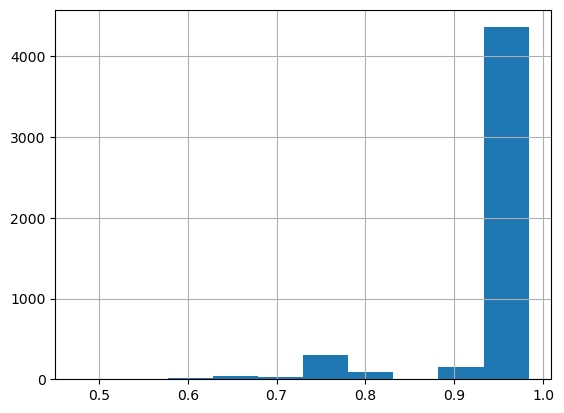

In [ ]:
df_test['pred_prob'].hist();

In [ ]:
df_test[df_test['pred_prob']<0.85][:500]

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label,pred_merchant,pred_prob
4,9796686754,Wal-Mart Super WAL-SAMS SPRINGFIELD MO. Channe...,Wal-Mart Super WAL-SAMS SPRINGFIELD MO. Type: ...,Wal-Mart Super WAL-SAMS SPRINGFIELD MO,Walmart,Smith''s,0,0.310292,Wal Wal-martsuper,0.799137
11,9799290885,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,Walmart,Synchrony,0,0.232759,Wal Wal-martsuper,0.775473
12,9798904474,Walmart.com Bentonville AR XX SIG PURCH 05/13 ...,Walmart.com Bentonville AR XX SIG PURCH 05/13 ...,Walmart.com Bentonville AR XX SIG PURCH 05/13 ...,Walmart,QuikTrip,0,0.075148,Wal Wal-martsuper,0.751793
17,9801927063,PURCHASE AUTHORIZED ON 05/11 WALMART.COM 800-9...,PURCHASE AUTHORIZED ON 05/11 WALMART.COM 800-9...,PURCHASE AUTHORIZED ON 05/11 WALMART.COM 800-9...,Walmart,Cash App,0,0.078535,Wal Wal-martsuper,0.735269
28,9799263021,05/13 22:02 WAL-MART # JONESBORO AR CKCD DEBIT...,05/13 22:02 WAL-MART # JONESBORO AR CKCD DEBIT...,05/13 22:02 WAL-MART # JONESBORO AR CKCD DEBIT,Walmart,Marathon Petroleum,0,0.257865,Wal Wal-martsuper,0.751371
...,...,...,...,...,...,...,...,...,...,...
4960,9807244423,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,Walmart,Spinstersis,0,0.051089,Wal Wal-martsuper,0.772779
4965,9808452776,Walmart.com 05/14 #XXXXX REFUND Walmart.com Be...,Walmart.com 05/14 #XXXXX REFUND Walmart.com Be...,Walmart.com 05/14 #XXXXX REFUND Walmart.com Be...,Walmart,K Stop Convenience,0,0.018743,Wal Wal-martsuper,0.713919
4971,9798778036,Point of Sale Debit L341 TIME 04:30 PM DATE 05...,Point of Sale Debit L341 TIME 04:30 PM DATE 05...,Point of Sale Debit L341 TIME 04:30 PM DATE 05...,Walmart,Ross Stores,0,0.114881,Wal Wal-martsuper,0.766499
4981,9807593604,CHECKCARD WALMART STA ELENA LA LIBERTAD XXXXX ...,CHECKCARD WALMART STA ELENA LA LIBERTAD XXXXX ...,CHECKCARD WALMART STA ELENA LA LIBERTAD XXXXX ...,Walmart,Lyft,0,0.116438,Wal Wal-martsuper,0.751746


In [ ]:
df_test.shape

(5000, 10)

In [ ]:
df_test['sentence'][100:150]

100    Deposit Debit Ca Earnin CEEEE_B Palo Alto CA D...
101    Zelle payment from AMY HAYES for \"vanishing b...
102    EARNIN CHGFC_B PALO ALTO CA 05/14. Channel: No...
103    PURCHASE AUTHORIZED ON 05/13 MCDONALD''S F IRV...
104    Debit Card Credit EARNIN CCHGA_B PALO ALTO CA....
105    Zelle payment from SUSAN BRODBECK BACsggj269q0...
106    POS Payment McDonalds 154-XXX VA # . Channel: ...
107    ONLINE TRANSFER FROM HUDSON A WAY2SAVE SAVINGS...
108    EARNIN CDHJA_B PALO ALTO CA 05/14. Channel: No...
109    Earnin CEGJA_B Palo Alto CA. Channel: None. Am...
110    ONLINE TRANSFER FROM BENNETT T WAY2SAVE SAVING...
111    Zelle payment from ALEXIS GAUDET BACxe32r3prx....
112    PURCHASE AMZN Mktp US*SY1BN Amzn.com/billWA XX...
113    CASH APP*ERIC LOLA BAR. Channel: None. Amount:...
114    Zelle payment from SHAVONNE MORENO BACpwpbspl0...
115    McDonalds 05-12 BROOKSVILLE FL DEBIT CARD PURC...
116    CHECKCARD CASH APP*WE DESIG XXXXX CA XXXXX XXX...
117    AMZN Mktp US*WN8Q06S Amz

In [ ]:
model.encode(df_test['sentence'][istart:istart+batch_size].tolist())

array([[-0.00816036,  0.27537555,  0.14324246, ...,  0.0999889 ,
        -0.0035936 ,  0.07809736],
       [ 0.02443847, -0.07863627,  0.01445072, ...,  0.02271993,
         0.03442278,  0.02410999],
       [-0.01848849,  0.26305526,  0.12530893, ...,  0.09496655,
         0.00565742,  0.07274164],
       ...,
       [ 0.02032459, -0.06118753,  0.01493401, ..., -0.00625443,
         0.10024939,  0.12695931],
       [-0.01988285, -0.1525213 ,  0.0045229 , ..., -0.01461221,
         0.02463034,  0.0660398 ],
       [-0.01051987, -0.06855395,  0.00723861, ..., -0.00558885,
         0.0144608 ,  0.05602989]], dtype=float32)

In [ ]:
df_test.loc[istart:istart+batch_size-1,'pred_merchant'].shape

(100,)

In [ ]:
df_test.loc[0:100,'label'].shape

(101,)

In [ ]:
df_test[0:100].shape

(100, 10)

In [ ]:
istart+batch_size

100

In [ ]:

len(predicted_merchant)

100

In [ ]:
tx_embedding = model.encode(df_test['sentence'][0:2])

In [ ]:
tx_embedding.shape

(2, 768)

torch.Size([2, 85500])

torch.return_types.max(
values=tensor([0.9616, 0.9750]),
indices=tensor([117,  17]))

tensor([117,  17])

In [ ]:
df_test['merchant_name_combined']

0         Wells Fargo
1         McDonald''s
2            Cash App
3             Verizon
4            Smith''s
            ...      
4995    Chumba Casino
4996            Zelle
4997           Crenco
4998          Empower
4999            Zelle
Name: merchant_name_combined, Length: 5000, dtype: string

In [ ]:
matched_merchants = similarities.max(axis=1)
matched_merchants

NameError: name 'similarities' is not defined

In [ ]:
similarity_score = matched_merchants[0]
similarity_score

tensor([0.9629, 0.9737])

In [ ]:
matched_merchants

NameError: name 'matched_merchants' is not defined

Load model

In [ ]:
print(sentence_transformers.__version__)

3.0.0


In [ ]:
from sentence_transformers import SentenceTransformerModelCardData
from datasets import load_dataset


In [ ]:
# 1. Load a model to finetune with 2. (Optional) model card data
model = SentenceTransformer(
    "microsoft/mpnet-base",
    model_card_data=SentenceTransformerModelCardData(
        language="en",
        license="apache-2.0",
        model_name="MPNet base trained on AllNLI triplets",
    )
)

# 3. Load a dataset to finetune on
dataset = load_dataset("sentence-transformers/all-nli",'pair-score')

No sentence-transformers model found with name microsoft/mpnet-base. Creating a new one with mean pooling.
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Generating train split:   0%|          | 0/942069 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/19657 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/19656 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'score'],
        num_rows: 942069
    })
    dev: Dataset({
        features: ['sentence1', 'sentence2', 'score'],
        num_rows: 19657
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'score'],
        num_rows: 19656
    })
})

In [ ]:
train_dataset = dataset['train']

In [ ]:
train_dataset[0]

{'sentence1': 'A person on a horse jumps over a broken down airplane.',
 'sentence2': 'A person is training his horse for a competition.',
 'score': 0.5}

In [ ]:
#train_dataloader = DataLoader(train_examples, shuffle=True, batch_size = 128)

In [ ]:
len(train_dataloader)

668

In [ ]:
#train_loss = losses.CosineSimilarityLoss(model)

In [ ]:
train_loss

NameError: name 'train_loss' is not defined

## Tune the model

In [ ]:
model.fit(train_objectives = [(train_dataloader, train_loss)], epochs = 1 , warmup_steps = 100)

Detected kernel version 4.14.343, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss
500,0.020500


In [ ]:
# save model

## Evaluation

In [ ]:
trx_descriptions = df_val['sentence'].tolist()
merchants = df_val['merchant_name_combined'].tolist()
trx_embeddings = model.encode(trx_descriptions)
merchants_embeddings = model.encode(merchants)

In [ ]:
print(trx_embeddings.shape)
print(merchants_embeddings.shape)

(9500, 768)
(9500, 768)


In [ ]:
import numpy as np

In [ ]:
## look into numba
cosine_similarity(trx_embeddings, merchants_embeddings).shape
df_val['cos_similarity']=np.diag(cosine_similarity(trx_embeddings, merchants_embeddings))

In [ ]:
df_val

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label,cos_similarity
0,9798760350,Debit Purchase Wal-mart Super Cbrookings Sd 05...,Debit Purchase Wal-mart Super Cbrookings Sd 05...,Debit Purchase Wal-mart Super Cbrookings Sd 05...,Walmart,Exotic S Shop,0,0.328529,0.000262
1,9806775557,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*JE...,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*JE...,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*JE...,Cash App,Acorns,0,0.265679,-0.010028
2,9798728894,MONEY TRANSFER AUTHORIZED ON 05/13 FROM Earnin...,MONEY TRANSFER AUTHORIZED ON 05/13 FROM Earnin...,MONEY TRANSFER AUTHORIZED ON 05/13 FROM Earnin...,Earnin,PayPal,0,0.207873,-0.003231
3,9799291124,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*JE...,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*JE...,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*JE...,Cash App,Wells Fargo,0,0.008904,0.001403
4,9799976650,Instant Pmt from Earnin RDBFA_B on 05/14 Ref# ...,Instant Pmt from Earnin RDBFA_B on 05/14 Ref# ...,Instant Pmt from Earnin RDBFA_B on 05/14 Ref# ...,Earnin,Venmo,0,0.054398,-0.010100
...,...,...,...,...,...,...,...,...,...
9495,9799636891,PURCHASE RETURN AUTHORIZED ON 05/13 AMZN Mktp ...,PURCHASE RETURN AUTHORIZED ON 05/13 AMZN Mktp ...,PURCHASE RETURN AUTHORIZED ON 05/13 AMZN Mktp ...,Amazon,TGI Friday''s,0,0.102636,0.001885
9496,9799365097,"AMZN Mktp US GE69A,2YL3 Amzn com WA,05-13-24,C...","AMZN Mktp US GE69A,2YL3 Amzn com WA,05-13-24,C...","AMZN Mktp US GE69A,2YL3 Amzn com WA,05-13-24,C...",Amazon,Amazon,1,0.840733,0.995985
9497,9814848095,ONLINE TRANSFER FROM NAME N WELLS FARGO CLEAR ...,ONLINE TRANSFER FROM NAME N WELLS FARGO CLEAR ...,ONLINE TRANSFER FROM NAME N WELLS FARGO CLEAR ...,Wells Fargo,Wells Fargo,1,0.888943,0.988127
9498,9799827250,MCDONALD''S F ROCKY RIVER OH 05/13. Channel: i...,MCDONALD''S F ROCKY RIVER OH 05/13. Type: merc...,MCDONALD''S F ROCKY RIVER OH 05/13,McDonald''s,Coca-Cola,0,0.085374,-0.001350


In [ ]:
while True:
    pass

KeyboardInterrupt: 

In [ ]:
validate_data[['label', 'true_label','cos_similarity']]

In [ ]:
# reducer = umap.UMAP(n_epochs=400,  n_neighbors=150, min_dist=0.1)
# reducer.fit(merchants_embeddings
# )
# embedding_2d = reducer.transform(merchants_embeddings)
# fig = px.scatter(embedding_2d, x=0, y=1,opacity=0.05, height=500, hover_name=names)
# fig.show()